In [1]:
import pandas as pd

# load the dataset
df = pd.read_csv('Weblog_v1.csv')

rs = 42

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15789 entries, 0 to 15788
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   IP address  15789 non-null  object
 1   Timestamp   15789 non-null  object
 2   Request     15789 non-null  object
 3   Staus       15789 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 493.5+ KB


In [2]:
# preview
df.head()

,IP address,Timestamp,Request,Staus
0,10.128.2.1,[29/Nov/2017:06:58:55,GET /login.php HTTP/1.1,200
1,10.128.2.1,[29/Nov/2017:06:59:02,POST /process.php HTTP/1.1,302
2,10.128.2.1,[29/Nov/2017:06:59:03,GET /home.php HTTP/1.1,200
3,10.131.2.1,[29/Nov/2017:06:59:04,GET /js/vendor/moment.min.js HTTP/1.1,200
4,10.130.2.1,[29/Nov/2017:06:59:06,GET /bootstrap-3.3.7/js/bootstrap.js HTTP/1.1,200


In [2]:
def extract_method_and_protocol(row):
    # function to extract HTTP request method and protocol from a request string
    request_splits = row['Request'].split()  # split request string by space
    row['Method'] = request_splits[0]
    row['Protocol'] = request_splits[-1]
    row['Request'] = ' '.join(request_splits[1:-1])  # stitch remaining request string back
    if '?' in row['Request']:
        row['Request'] =row['Request'][0:row['Request'].index('?')]
    row['Timestamp']=row['Timestamp'][0:-5]
    return row

df = df.apply(extract_method_and_protocol, axis=1)

# show the result
df.head()

,IP address,Timestamp,Request,Staus,Method,Protocol
0,10.128.2.1,[29/Nov/2017:06:,/login.php,200,GET,HTTP/1.1
1,10.128.2.1,[29/Nov/2017:06:,/process.php,302,POST,HTTP/1.1
2,10.128.2.1,[29/Nov/2017:06:,/home.php,200,GET,HTTP/1.1
3,10.131.2.1,[29/Nov/2017:06:,/js/vendor/moment.min.js,200,GET,HTTP/1.1
4,10.130.2.1,[29/Nov/2017:06:,/bootstrap-3.3.7/js/bootstrap.js,200,GET,HTTP/1.1


In [26]:
# correct the incorrect dataframe types
df['Staus'] = df['Staus'].astype(int)  # set status code to int
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='[%d/%b/%Y:%H:')  # set date time to pandas datatime obj 

# create a mask to filter all images
mask = (df['Request'].str.endswith('.gif') | df['Request'].str.endswith('.jpg') | df['Request'].str.endswith('.jpeg') | df['Request'].str.endswith('.js')| df['Request'].str.endswith('.css')| df['Request'].str.endswith('.woff2'))
print("# Rows before:", len(df))

# invert the mask, only keep records without .gif, .jpg and .jpeg in the request column
df2 = df[~mask]

print("After images removal", len(df2))

# second mask, remove all unsuccessful requests (code != 200)
df2 = df2[df2['Staus'] == 200]
print("After unsuccessful requests removal", len(df2))

# Rows before: 15789
After images removal 10849
After unsuccessful requests removal 7089


In [27]:
df.head()

,IP address,Timestamp,Request,Staus,Method,Protocol
0,10.128.2.1,2017-11-29 06:00:00,/login.php,200,GET,HTTP/1.1
1,10.128.2.1,2017-11-29 06:00:00,/process.php,302,POST,HTTP/1.1
2,10.128.2.1,2017-11-29 06:00:00,/home.php,200,GET,HTTP/1.1
3,10.131.2.1,2017-11-29 06:00:00,/js/vendor/moment.min.js,200,GET,HTTP/1.1
4,10.130.2.1,2017-11-29 06:00:00,/bootstrap-3.3.7/js/bootstrap.js,200,GET,HTTP/1.1


<Axes: xlabel='Method', ylabel='count'>

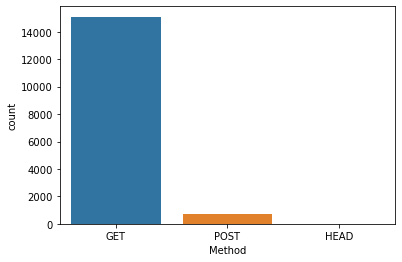

In [28]:
import seaborn as sns

df['Method'].value_counts()
sns.countplot(x = 'Method', data=df)

In [29]:

Requests=df2.groupby(['Timestamp'])['Request'].apply(list)
print(Requests)

Timestamp
2017-11-07 23:00:00                                               [/, /]
2017-11-08 00:00:00                             [/login.php, /login.php]
2017-11-08 01:00:00                             [/login.php, /login.php]
2017-11-08 03:00:00                             [/login.php, /login.php]
2017-11-08 05:00:00                             [/login.php, /login.php]
                                             ...                        
2018-03-01 13:00:00    [/login.php, /img/ruet.png, /login.php, /login...
2018-03-02 04:00:00    [/login.php, /login.php, /login.php, /login.ph...
2018-03-02 05:00:00                                          [/sign.php]
2018-03-02 06:00:00    [/login.php, /login.php, /img/ruet.png, /sign....
2018-03-02 15:00:00    [/login.php, /home.php, /archive.php, /compile...
Name: Request, Length: 483, dtype: object


In [30]:
request_list=list(Requests)
token={}
counter=0
for i in range(0,len(request_list)):
    for j in range(0,len(request_list[i])):
            if request_list[i][j] in token:
                request_list[i][j] = token[request_list[i][j]]
            else:
                token[request_list[i][j]]=str(counter)
                request_list[i][j] = str(counter)
                counter+=1

In [37]:
from apyori import apriori

results = list(apriori(request_list, min_support=0.05))

In [38]:
def find_key_by_value(input_dict, search_value):
    final=[]
    for i in search_value:
        for key, value in input_dict.items():
            if value == i:
                final.append(key)   

    return final



def convert_apriori_results_to_pandas_df(results):
    rules = []
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([' , '.join(find_key_by_value(token,rule.items_base)), ' , '.join(find_key_by_value(token,rule.items_add)),
            rule_set.support, rule.confidence, rule.lift])
            # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support',
    'Confidence', 'Lift'])
        
result_df = convert_apriori_results_to_pandas_df(results)
result_df = result_df.sort_values(by='Lift', ascending=False) 
print(result_df.head(20))


                                      Left_side  ...      Lift
1343    /archive.php , /contest.php , /home.php  ...  8.781818
1324              /description.php , /login.php  ...  8.781818
723               /description.php , /login.php  ...  8.537879
728                 /archive.php , /contest.php  ...  8.537879
1339   /archive.php , /login.php , /contest.php  ...  8.523529
1328               /description.php , /home.php  ...  8.523529
1333                /archive.php , /contest.php  ...  8.490234
1334  /description.php , /login.php , /home.php  ...  8.490234
743             /contestproblem.php , /home.php  ...  8.473684
738         /contestsubmission.php , /login.php  ...  8.473684
1178                /archive.php , /contest.php  ...  8.286765
1173               /description.php , /home.php  ...  8.286765
873                   /details.php , /login.php  ...  8.214286
878          /contestproblem.php , /contest.php  ...  8.214286
740            /contestproblem.php , /login.php  ...  8